In [3]:
# import necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [4]:
orders = pd.read_csv('./data/Orders.csv')
returns = pd.read_csv('./data/Returns.csv')

pd.set_option('display.max_columns',None)
pd.set_option('display.min_rows',0)
pd.set_option('display.max_rows',100)

## Part I: Preprocessing and EDA

- The data comes from a global e-retailer company, including orders from 2012 to 2015. Import the **Orders** dataset and do some basic EDA. 
- For problem 1 to 3, we mainly focus on data cleaning and data visualizations. You can use all the packages that you are familiar with to conduct some plots and also provide **brief interpretations** about your findings.

### Problem 1: Dataset Import & Cleaning
Check **"Profit"** and **"Sales"** in the dataset, convert these two columns to numeric type. 

In [5]:
orders.Profit = orders.Profit.replace('[\$,]', '', regex=True).astype(float)
orders.Sales = orders.Sales.replace('[\$,]', '', regex=True).astype(float)

### Problem 2: Inventory Management
- Retailers that depend on seasonal shoppers have a particularly challenging job when it comes to inventory management. Your manager is making plans for next year's inventory.
- He wants you to answer the following questions:
    1. Is there any seasonal trend of inventory in the company?
    2. Is the seasonal trend the same for different categories?

In [7]:
orders['Month'] = pd.DatetimeIndex(orders['Order.Date']).month

def month_to_season(month):
    if month in [3,4,5]:
        month = '1_spring'
    elif month in [6,7,8]:
        month = '2_summer'
    elif month in [9,10,11]:
        month = '3_fall'
    else:
        month = '4_winter'
    return(month)

orders['Season'] = orders.Month.apply(month_to_season)

In [8]:
season_quantity = orders.groupby(['Season']).agg({"Quantity": 'sum'})

In [9]:
season_quantity

,Quantity
Season,
1_spring,34052
2_summer,46651
3_fall,59161
4_winter,38448


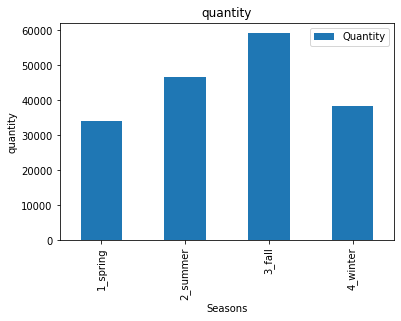

In [10]:
season_quantity.plot.bar()
plt.title('quantity')
plt.xlabel('Seasons')
plt.ylabel('quantity')
plt.show()

In [16]:
Furniture = orders["Category"]=='Furniture'
test_f = orders[Furniture]
Technology = orders["Category"]=='Technology'
test_t = orders[Technology]
Office_Supplies = orders["Category"]=='Office Supplies'
test_os = orders[Office_Supplies]

test_category = pd.DataFrame({'Office Supplies':test_os.Season.value_counts(),'Furniture': test_f.Season.value_counts(), 'Technology': test_t.Season.value_counts()})

test_category = test_category.sort_index()

test_category

,Office Supplies,Furniture,Technology
1_spring,6054,1856,1916
2_summer,8381,2488,2693
3_fall,10170,3347,3308
4_winter,6684,2169,2224


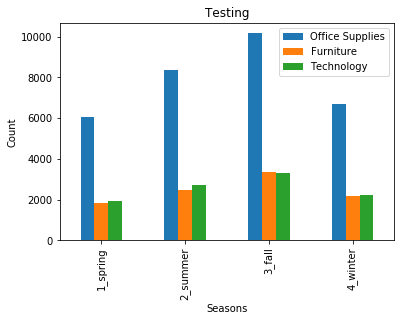

In [17]:
test_category.plot.bar()
plt.title('Testing')
plt.xlabel('Seasons')
plt.ylabel('Count')
plt.show()

Furniture category had a slight drop in sales in spring and summer, but overall all categories followed a similar trend from overall (Winter < Spring < Summer < Fall)

# Problem 3: Why Did Customers Make Returns? 

### *Question 1: How much profit did we lose due to returns each year?*

In [47]:
# merge returns and orders dataframe. Create new column year from order.date
returns = returns.rename(columns={'Order ID': 'Order.ID'})
losses = pd.merge(orders, returns, on='Order.ID')
losses['Year'] = pd.DatetimeIndex(losses['Order.Date']).year

In [31]:
# groupby year and aggregate sum of profits per year
profit_loss = losses.groupby('Year').agg({'Profit':'sum'})
profit_loss = profit_loss.rename(columns={'Profit': 'Profit Loss'})
profit_loss

,Profit Loss
Year,
2012,17477.26
2013,9269.89
2014,17510.63
2015,17112.97


Text(0.5, 1.0, 'Profit Loss Due to Returns By Year')

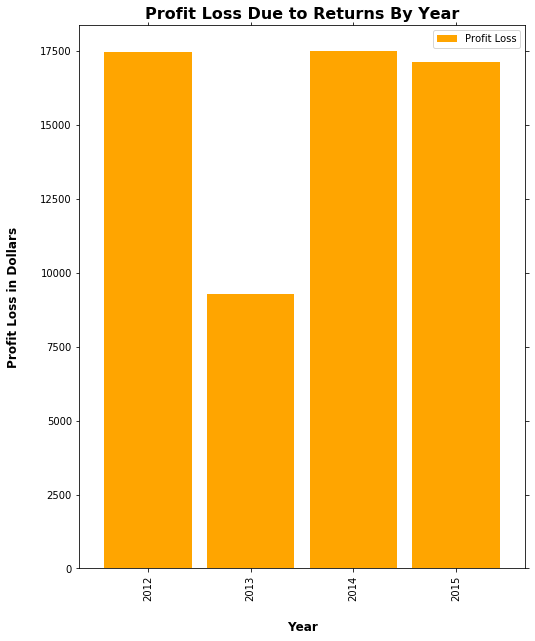

In [32]:
# plotting profit loss
loss = profit_loss.plot(kind='bar', figsize=(8, 10), color='orange', zorder=2, width=0.85)
loss.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
loss.set_xlabel("Year", labelpad=20, weight='bold', size=12)
loss.set_ylabel("Profit Loss in Dollars", labelpad=20, weight='bold', size=12)
loss.set_title("Profit Loss Due to Returns By Year", weight='bold', size=16)

### *Question 2: How many customers returned more than once? More than 5 times?*

In [33]:
return_count = losses.groupby(['Customer.ID']).agg({'Returned':'count'})

In [44]:
one = return_count[return_count > 1].dropna()
five = return_count[return_count > 5].dropna()

In [45]:
print('Number of customers who returned more than once: ',len(one.index))
print('Number of customers who returned more than five times: ',len(five.index))

Number of customers who returned more than once:  547
Number of customers who returned more than five times:  46


### *Question 3: Which regions are more likely to return orders?*

In [53]:
# merging return and orders. manipulating Returned column
or_merge = pd.merge(orders, returns,on=["Order.ID"], how="left")
or_merge['Returned'].fillna('No', inplace=True)
or_merge['Returned'] = or_merge['Returned'].map({'Yes': 1, 'No':0})

In [70]:
# aggregating return ratios per region
region_return = or_merge.groupby('Region_x').agg({'Returned':'mean'}).sort_values(by='Returned')
region_return

,Returned
Region_x,
Eastern Africa,0.024725
Central Africa,0.026439
Eastern Europe,0.027469
Central US,0.031855
Northern Europe,0.034483
Canada,0.039062
Western Europe,0.039606
North Africa,0.039906
Caribbean,0.040828


Text(0.5, 1.0, 'Number of Returned Products by Region')

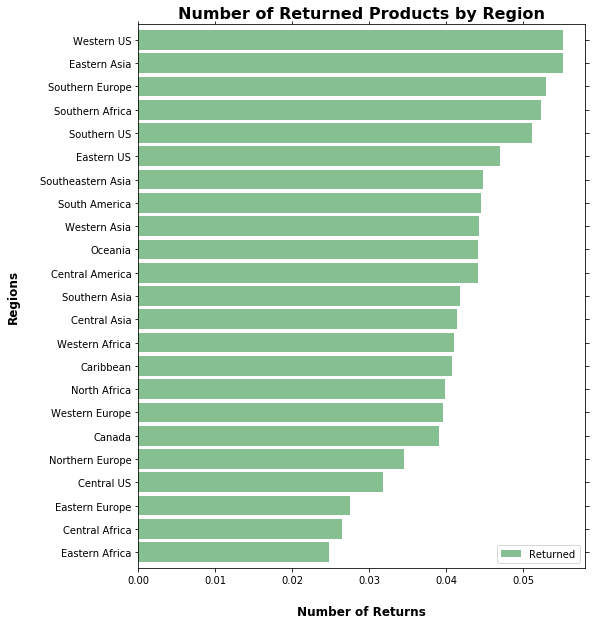

In [69]:
# plotting return ratios per region
region_fig = region_return.plot(kind='barh', figsize=(8, 10), color='#86bf91', zorder=2, width=0.85)
region_fig.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
region_fig.set_xlabel("Number of Returns", labelpad=20, weight='bold', size=12)
region_fig.set_ylabel("Regions", labelpad=20, weight='bold', size=12)
region_fig.set_title("Number of Returned Products by Region", weight='bold', size=16)

### *Question 4: Which categories (sub-categories) of products are more likely to be returned?*

In [75]:
category_return_count = losses.groupby(['Category']).agg({'Returned':'count'})
category_return_ratio = or_merge.groupby(['Category']).agg({'Returned':'mean'})

Text(0.5, 1.0, 'Number of Products Returned by Category (ratio)')

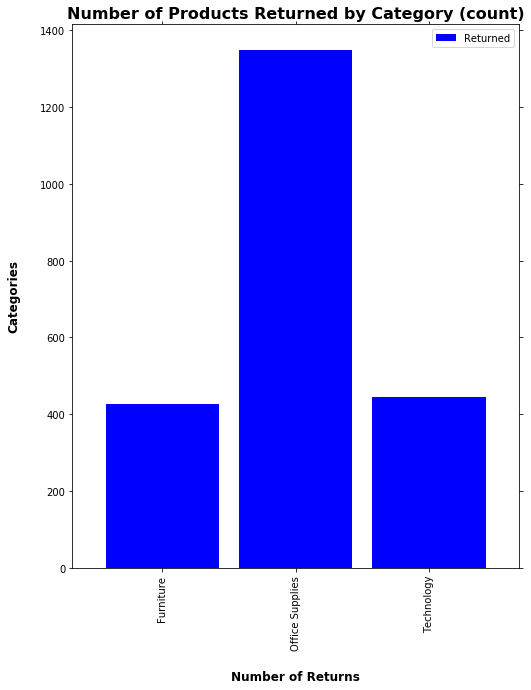

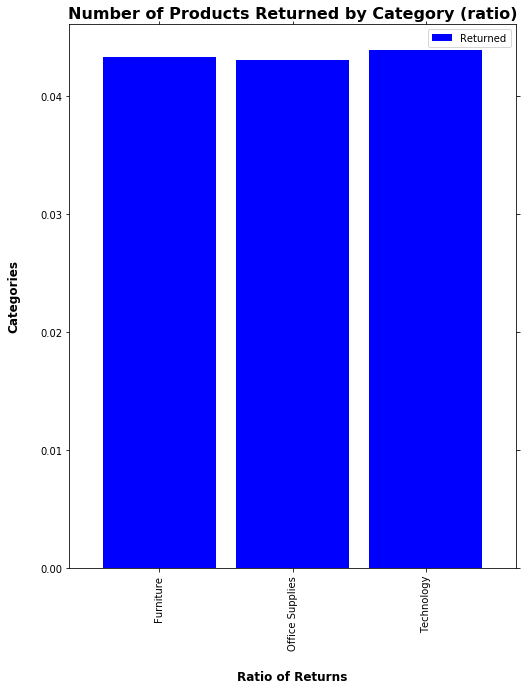

In [88]:
cat_fig = category_return_count.plot(kind='bar', figsize=(8, 10), color='blue', zorder=2, width=0.85)
cat_fig.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
cat_fig.set_xlabel("Number of Returns", labelpad=20, weight='bold', size=12)
cat_fig.set_ylabel("Categories", labelpad=20, weight='bold', size=12)
cat_fig.set_title("Number of Products Returned by Category (count)", weight='bold', size=16)

cat_fig_ratio = category_return_ratio.plot(kind='bar', figsize=(8, 10), color='blue', zorder=2, width=0.85)
cat_fig_ratio.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
cat_fig_ratio.set_xlabel("Ratio of Returns", labelpad=20, weight='bold', size=12)
cat_fig_ratio.set_ylabel("Categories", labelpad=20, weight='bold', size=12)
cat_fig_ratio.set_title("Number of Products Returned by Category (ratio)", weight='bold', size=16)

In [85]:
subcategory_return_count = losses.groupby(['Sub.Category']).agg({'Returned':'count'})
subcategory_return_count = subcategory_return_count.sort_values(by=['Returned'])

subcategory_return_ratio = or_merge.groupby('Sub.Category').agg({'Returned':'mean'})
subcategory_return_ratio = subcategory_return_ratio.sort_values(by='Returned')

Text(0.5, 1.0, 'Number of Products Returned in Each Subcatecory (ratio)')

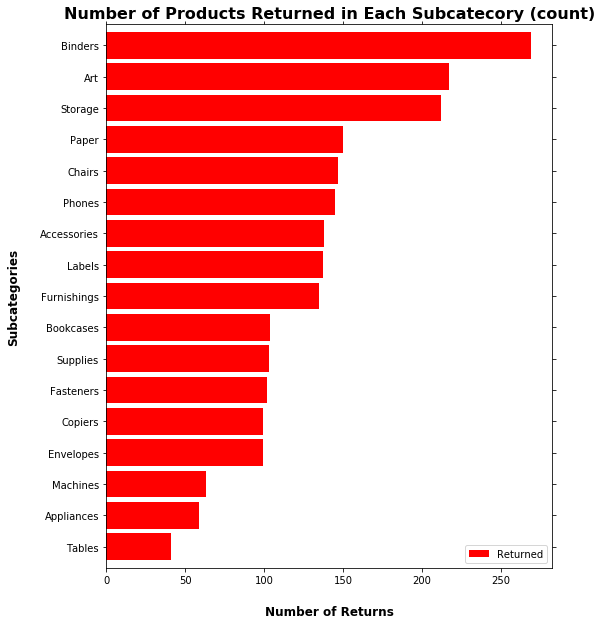

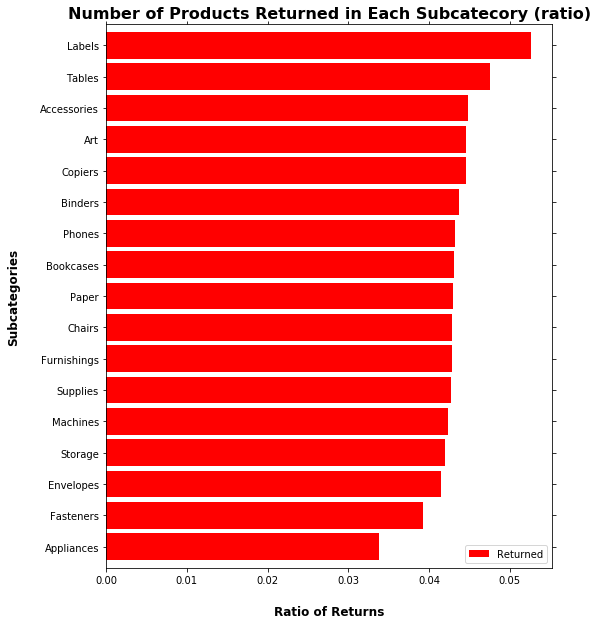

In [87]:
subcat_fig = subcategory_return_count.plot(kind='barh', figsize=(8, 10), color='red', zorder=2, width=0.85)
subcat_fig.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
subcat_fig.set_xlabel("Number of Returns", labelpad=20, weight='bold', size=12)
subcat_fig.set_ylabel("Subcategories", labelpad=20, weight='bold', size=12)
subcat_fig.set_title("Number of Products Returned in Each Subcatecory (count)", weight='bold', size=16)

subcat_fig_ratio = subcategory_return_ratio.plot(kind='barh', figsize=(8, 10), color='red', zorder=2, width=0.85)
subcat_fig_ratio.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
subcat_fig_ratio.set_xlabel("Ratio of Returns", labelpad=20, weight='bold', size=12)
subcat_fig_ratio.set_ylabel("Subcategories", labelpad=20, weight='bold', size=12)
subcat_fig_ratio.set_title("Number of Products Returned in Each Subcatecory (ratio)", weight='bold', size=16)

# Problem 4: Feature Engineering

### *Step 1: Create the Dependent Variable*

In [8]:
return1 = pd.read_csv('./data/Returns.csv')

In [43]:
import numpy as np
or_merge['Returned'] = or_merge['Returned'].replace(np.nan, "No")

### *Step 2: New Feature - Process.Time*

In [44]:
or_merge['Order.Date'] = pd.to_datetime(or_merge['Order.Date'])
or_merge['Ship.Date'] = pd.to_datetime(or_merge['Ship.Date'])

In [45]:
or_merge['Process.Time_Days'] = (or_merge['Ship.Date'] - or_merge['Order.Date']).dt.days

### *Step 3: How many times product has been returned*

In [46]:
return_count = or_merge[or_merge["Returned"]=='Yes']\
.groupby(['Product.ID']).agg({'Returned':'count'})
return_count = return_count.reset_index()

In [47]:
return_count = return_count.rename(columns={'Returned': 'Num of Times Returned'})

In [48]:
or_merge = pd.merge(or_merge, return_count, on=["Product.ID"], how="left")

In [50]:
or_merge['Num of Times Returned'] = or_merge['Num of Times Returned'].replace(np.nan, 0)